In [5]:
import scipy.io
import numpy as np
from tqdm import tqdm
from harp_beam import compute_EEPs, power_EEPs, compute_beamforming
from plot_utils import plot_beamforming_results, plot_station_beam_pattern, plot_stefcal_comparison

In [6]:
## Q 2. plot all the 256 EEPs and their average (AEP)

num_dir = 256
theta = np.linspace(-np.pi/2, np.pi/2, num_dir)
phi = np.zeros_like(theta)

v_theta_polY, v_phi_polY, v_theta_polX, v_phi_polX = compute_EEPs(theta.copy()[:, None], phi.copy()[:, None])

# Compute EEPs
complex_E_fields = compute_EEPs(theta.copy()[:, None], phi.copy()[:, None])

# Compute power EEPs
power_E_fields = power_EEPs(*complex_E_fields)

# plot EEPs and AEPs
#plot2(theta, *power_E_fields)

TypeError: compute_EEPs() missing 8 required positional arguments: 'alpha_te', 'alpha_tm', 'coeffs_polX', 'coeffs_polY', 'pos_ant', 'num_mbf', 'max_order', and 'k0'

In [ ]:
## Q 3. the model matrix, the covariance matrix, the exact gain values and (my) gain estimations are loaded as

filename_vismat = f"data_20feb2024_2330_100MHz.mat"
mat = scipy.io.loadmat(filename_vismat)
R = np.array(mat['R']) # covariance matrix
M_AEP = np.array(mat['M_AEP']) # model matrix using AEP
M_EEPs = np.array(mat['M_EEPs']) # model matrix using all EEPs
g_sol = np.array(mat['g_sol']) # exact gain solution
g_AEP = np.array(mat['g_AEP']) # estimation using M_AEP (using this for question 5 and 6 only if you haven't been able to complete question 3 and 4)
g_EEPs = np.array(mat['g_EEPs']) # estimation using M_EEPs

In [2]:
# Q3/4 StEFCal algorithm
def stefcal(M, R, g_sol, max_iteration=1000, threshold=1e-5, algorithm2=False):
    convergence = []
    abs_gain_error = []
    abs_amp_error = []
    abs_phase_error = []

    # Number of antennas
    N = R.shape[0]

    # Initial gain matrix G
    G = np.eye(N, dtype=complex) # Identity matrix

    # Iterative loop
    for i in tqdm(range(max_iteration)):

        # Last iteration of G for comparison
        G_prev = G.copy()

        for p in range(N):  # Loop over antennas p
            if algorithm2:
                z = np.dot(G, M[:, p])  # Use G[i]
            else:
                z = np.dot(G_prev, M[:, p])  # Use G[i-1]
            gp = np.dot(np.conjugate(R[:, p]), z) / np.dot(np.conjugate(z), z)  # Calculate new gain for antenna p
            G[p, p] = gp # Update the gain for antenna p in the matrix


        # Convergence check even iterations
        if i % 2 == 0:
            
            delta_G = np.linalg.norm(G - G_prev, 'fro') / np.linalg.norm(G, 'fro')
            convergence.append(delta_G)
            if delta_G < threshold:
                print(f"Convergence reached after {i+1} iterations.")
                break
            else:
                G = (G + G_prev) / 2
                
                # Calculate errors
                G_diagonal = G.diagonal().reshape(-1, 1)
                abs_gain_error.append(np.linalg.norm(np.abs(G_diagonal - g_sol), 'fro') / np.linalg.norm(g_sol, 'fro'))
                abs_amp_error.append(np.linalg.norm(np.abs(G_diagonal) - np.abs(g_sol), 'fro') / np.linalg.norm(g_sol, 'fro'))
                abs_phase_error.append(np.linalg.norm(np.angle(G_diagonal) - np.angle(g_sol), 'fro')/ np.linalg.norm(g_sol, 'fro'))

    return G, convergence, abs_gain_error, abs_amp_error, abs_phase_error

In [3]:
## Algorithm 1
# run stefcal
G_AEP1, *algo1_AEP = stefcal(M_AEP, R, g_sol)
G_EEPs1, *algo1_EEP = stefcal(M_EEPs, R, g_sol) 


## Algorithm 2
# run stefcal
G_AEP2, *algo2_AEP = stefcal(M_AEP, R, g_sol, algorithm2=True)
G_EEPs2, *algo2_EEP = stefcal(M_EEPs, R, g_sol, algorithm2=True)

# plot stefcal
plot_stefcal_comparison(algo1_AEP, algo1_EEP, algo2_AEP, algo2_EEP)

NameError: name 'M_AEP' is not defined

In [4]:
# Q 5. Calibrating EEP using Array Pattern

freq = 100
c0 = 299792458  # speed of light
k0 = 2 * np.pi * freq / c0 * 10**6  # wavenumber
antenna = 'SKALA41'  # antenna name
layout = 'random'  # array layout
data_folder = 'harp_beam'
filename_eep = f"data_EEPs_{antenna}_{layout}_{freq}MHz.mat"
mat = scipy.io.loadmat(filename_eep)
pos_ant = np.array(mat['pos_ant'])

# Define theta_range based on your system (same as your original theta_range)
theta = np.linspace(-np.pi/2, np.pi/2, num_dir)
phi = 0
theta0 = 0  # Define theta0 based on your system
phi0 = 0  # Define phi0 based on your system

# G values from Algorithm 1
G_EEPs = G_EEPs1.diagonal().reshape(-1,1)
G_AEP = G_AEP1.diagonal().reshape(-1,1)


# AP g_sol
AP_sol_polY, AP_sol_polX = compute_beamforming(g_sol, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP g_EEPs
AP_g_EEPs_polY, AP_g_EEPs_polX = compute_beamforming(g_EEPs, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP g_AEP
AP_g_AEP_polY, AP_g_AEP_polX = compute_beamforming(g_AEP, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP G_EEPs from Algorithm 1
AP_G_EEPs_polY, AP_G_EEPs_polX = compute_beamforming(G_EEPs, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)

# AP G_AEP1 from Algorithm 1
AP_G_AEP_polY, AP_G_AEP_polX = compute_beamforming(G_AEP, *complex_E_fields, pos_ant, theta, phi, theta0, phi0)


# Plot beamforming results
plot_beamforming_results(theta, [AP_sol_polY, AP_G_EEPs_polY, AP_G_AEP_polY],
                        [AP_sol_polX, AP_G_EEPs_polX, AP_G_AEP_polX],
                        ['Gain Solutions', 'EEPs', 'AEP'],
                        ['solid', 'dashed', 'dashed'],)

NameError: name 'num_dir' is not defined

/Users/maxtalberg/Documents/Max/Cambridge2324/Lent/SKA/Coursework/harp_beam/src/plots.py:238: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = plt.pcolormesh(x, y, APy, cmap=cmap)
/Users/maxtalberg/Documents/Max/Cambridge2324/Lent/SKA/Coursework/harp_beam/src/plots.py:248: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = plt.pcolormesh(x, y, APx, cmap=cmap)


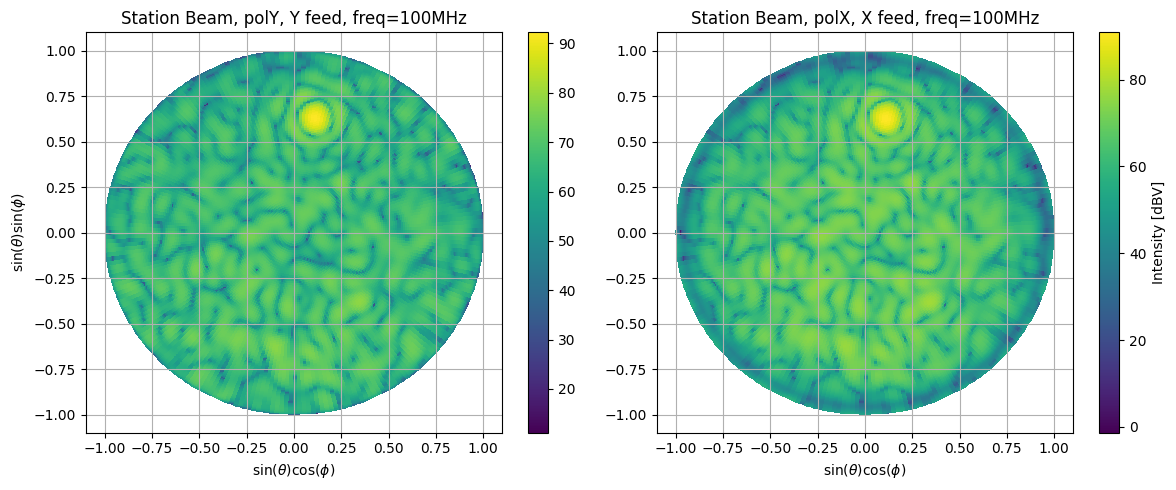

In [10]:
# q6. Plot calibrated station beam in sine-cosine space

# Create a grid for theta and phi
theta_vals = np.linspace(-np.pi/2, np.pi/2, num=256)  # -90 to 90 degrees for theta
phi_vals = np.linspace(-np.pi, np.pi, num=256)  # -180 to 180 degrees for phi
theta_grid, phi_grid = np.meshgrid(theta_vals, phi_vals, indexing='ij')
theta0_rad = np.radians(40)
phi0_rad = np.radians(80)

# Gain from Algorithm 1
G = G_EEPs1.diagonal().reshape(-1, 1)

AP_ploY, AP_polX = compute_beamforming(G, *complex_E_fields, pos_ant, theta_vals, phi_vals, theta0_rad, phi0_rad)

# Map theta and phi to sine-cosine coordinates
x = np.sin(theta_grid) * np.cos(phi_grid)
y = np.sin(theta_grid) * np.sin(phi_grid)

# Create the plot using pcolormesh, which is more appropriate for spherical data
plot_station_beam_pattern(x, y, AP_ploY, AP_polX)